# Часть 1. Проверка гипотезы в Python и составление аналитической записки

## Цели и задачи проекта

**Цель проекта:** проверка гипотезы о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении Yandex книги, чем пользователи из Москвы.

**Задачи в рамках проекта:**

- Проверка базы данных на наличие дубликатов, в случае их обнаружение - удаление лишних строк

- Сравнение размера групп (Москва и Санкт-Петербург) с вычислением описательных статистик: среднего, стандартного отклонения, медианы и квартилей

- Визуализация распределений при помощи гистограммы и "ящика с усами" для проверки нормальности распределения

- Проведение одностороннего t-теста для проверки статистической значимости полученного результата

- Подготовка аналитической записки с результатами проверки гипотезы

## Описание данных

Таблица включает 4 столбца:

- *Unnamed*: 0 - предположительно, столбец с порядковым номером

- *city* - название города

- *puid* - id пользователей

- *hours* - время (в часах), проведенное за чтением и прослушиванием книг в приложении 

## Содержимое проекта

**1.Загрузка данных и знакомство с ними:**

- Загрузка данных

- Проверка базы данных на наличие дубликатов

- Проверка на аномалии и выбросы

- Сравнение размеров групп и статистики

- Визуализация распределений

**2. Проверка гипотезы:**

- Двухвыборочный t-тест (односторонний) - использую t-test Уэлча и тест Манна-Уитни

**3. Аналитическая записка**

## Загрузка данных и знакомство с ними

In [1]:
# Импортируем необходимые для дальнейшей работы библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Загрузим данные пользователей из Москвы и Санкт-Петербурга
df = pd.read_csv('/datasets/yandex_knigi_data.csv')

In [3]:
# Проверим содержание таблицы
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434
5,5,Москва,352567,8.206369
6,6,Москва,439493,0.857758
7,7,Москва,494541,0.035072
8,8,Москва,647235,12.000076
9,9,Москва,656480,0.973032


Предположение о содержании столбцов, высказанное в пункте с описанием данных, выглядит правдоподобно. 

Пропуски в столбцах отсутствуют.

In [4]:
# Проверим дубликаты в столбце puid
duplicates = df['puid'].duplicated().sum()
print(f'Количество дубликатов по id пользователей: {duplicates}')

Количество дубликатов по id пользователей: 244


In [5]:
# Удалим дубликаты по столбцу puid, сохраняя первое вхождение. Проверим наличие дубликатов после этой операции
df = df.drop_duplicates(subset = 'puid', keep = 'first')
duplicates = df['puid'].duplicated().sum()
print(f'Количество дубликатов по id пользователей после удаления: {duplicates}')

Количество дубликатов по id пользователей после удаления: 0


Дубликаты удалены

In [6]:
# Проверка на аномалии (выбросы)
print("\nКоличество строк с hours < 0 или null:")
print(df[df['hours'].isna() | (df['hours'] < 0)].shape[0])


Количество строк с hours < 0 или null:
0


In [7]:
# Разделение данных по городам
moscow_data = df[df['city'] == 'Москва']['hours']
spb_data = df[df['city'] == 'Санкт-Петербург']['hours']

In [8]:
# Сравним размеры двух групп (по городам)
group_sizes = df.groupby('city').size()
print('\nРазмеры групп:')
print(group_sizes)


Размеры групп:
city
Москва             6234
Санкт-Петербург    2306
dtype: int64


Численность пользователей из Москвы в 2,7 раз больше численности пользователей из Петербурга в рамках эксперементальных групп

In [9]:
# Сравним статистические показатели по городам
stats_by_cities = df.groupby('city')['hours'].describe()
print('\nОписательные статистики по городам:')
print(stats_by_cities)


Описательные статистики по городам:
                  count       mean        std       min       25%       50%  \
city                                                                          
Москва           6234.0  10.881092  36.851683  0.000018  0.059903  0.924498   
Санкт-Петербург  2306.0  11.264433  39.831755  0.000025  0.060173  0.875355   

                      75%         max  
city                                   
Москва           5.939972  857.209373  
Санкт-Петербург  6.138424  978.764775  


Значения среднего, стандартного отклонения, минимума, макисмума, 25%-го и 75%-го квартилей выше у выборки пользователей из Петербурга. При этом показатель медианы (50%) выше у у пользователей, относящихся к московской выборке 

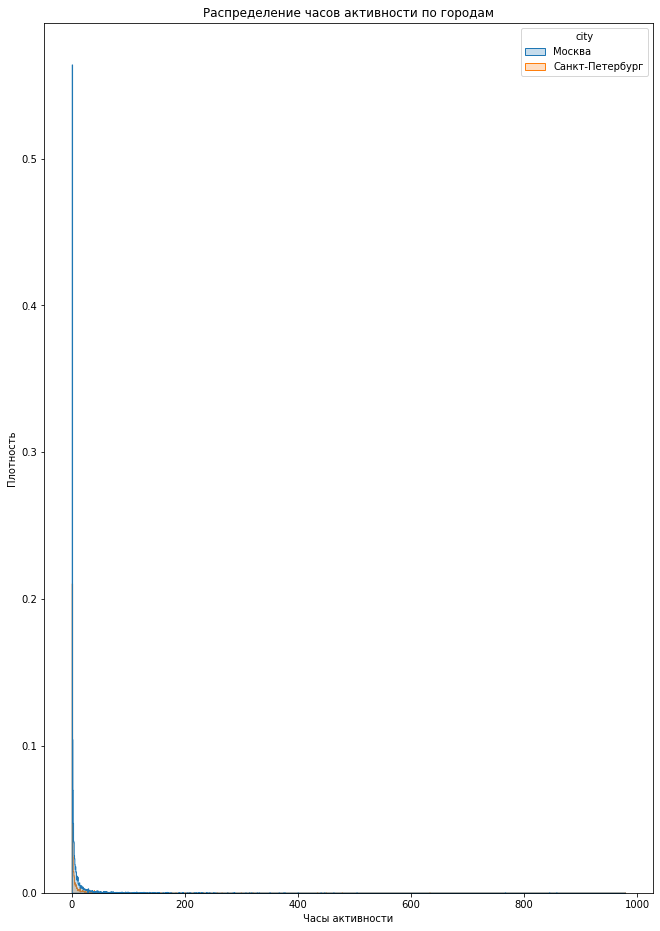

In [10]:
# Визуализируем распределение часов активности по городам с помощью гистограммы
plt.figure(figsize = (24, 16))
plt.subplot(1, 2, 1)
sns.histplot(data = df, x = 'hours', hue = 'city', element = 'step', stat = 'density')
plt.title('Распределение часов активности по городам')
plt.xlabel('Часы активности')
plt.ylabel('Плотность')
plt.show()

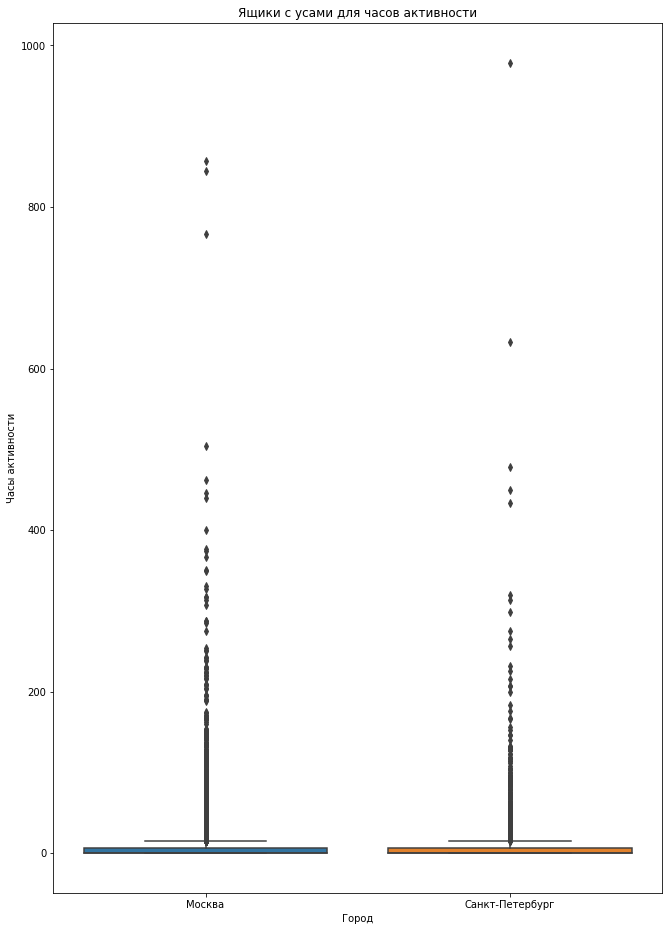

In [11]:
# Визуализируем распределение часов активности по городам с помощью "ящика с усами"
plt.figure(figsize = (24, 16))
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='city', y='hours')
plt.title('Ящики с усами для часов активности')
plt.xlabel('Город')
plt.ylabel('Часы активности')
plt.show()

Графики не демонстрируют значительных различий между показателями в выборках пользователей из Москвы и Петербурга. У петербургской выборки "ящик с усами" имеет более длинный хвост, однако основной массив пользователей демонстрирует примерно похожее поведение с московскими пользователями

## Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробую статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [12]:
# Примерные данные
df_m = np.array([1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3])
df_s = np.array([2.0, 2.2, 2.4, 2.5, 2.6, 2.7, 2.9])

In [13]:
# 1. Проверка нормальности распределения (тест Шапиро-Уилка)
p_m = shapiro(df_m).pvalue
p_s = shapiro(df_s).pvalue

print(f"p-значение для Москвы: {p_m:.4f}")
print(f"p-значение для СПб: {p_s:.4f}")

p-значение для Москвы: 0.9493
p-значение для СПб: 0.9920


In [14]:
# 2. Выбор критерия
if p_m > 0.05 and p_s > 0.05:
    print("Обе выборки распределены нормально. Применяем t-test (с поправкой Уэлча)")
    stat, p = ttest_ind(df_s, df_m, equal_var=False, alternative='greater')
else:
    print("Хотя бы одна из выборок НЕ нормально распределена. Применяем U-test (Манна-Уитни)")
    stat, p = mannwhitneyu(df_s, df_m, alternative='greater')

print(f"p-значение выбранного теста: {p:.4f}")

Обе выборки распределены нормально. Применяем t-test (с поправкой Уэлча)
p-значение выбранного теста: 0.0014


Поскольку мы имеем дело с нормальным распределением, далее применим t-test с поправкой Уэлча для проверки гипотез

In [15]:
# Проводим одноторонний t-тест Уэлча (т.к. размеры выборок по городам заметно отличаются)
# Уровень значимости
alpha = 0.05

In [16]:
# t-тест
stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    moscow_data,
    spb_data,
    alternative='less' 
)

In [17]:
# Интерпретация
if p_value_welch_ttest > alpha:
    print(f'p-value теста Уэлча = {round(p_value_welch_ttest, 4)}')
    print('Нулевая гипотеза подтверждается: средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается')
else:
    print(f'p-value теста Уэлча = {round(p_value_welch_ttest, 4)}')
    print('Нулевая гипотеза отвергается: средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо')

p-value теста Уэлча = 0.3382
Нулевая гипотеза подтверждается: средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается


## Аналитическая записка



Для проверки результата теста использовались t-test Уэлча при уровне статистической значимости 5% (alpha=0.05). 

В результате анализа **не удалось** найти статистическое подтверждения альтернативной гипотезе о том, что петербургские пользователи проводят больше времени за прочитыванием и прослушиванием контента в приложении. Показатель p-value значительно превышает alpha, и нулевая гипотеза об отсутствии различий между двумя выборками не выявлена.

Подобный результат может быть связан с особенностями выборок (московская выборка численно в 2.7 раза превышает петербургскую, и жители двух крупных городов на деле демонстрируют очень похожее поведение в контексте привычек к чтению и прослушиванию книг).

# Часть 2. Анализ результатов A/B-тестирования

## Цели исследования.



**Цель исследования:** Определить, приводит ли новый интерфейс к статистически значимому увеличению доли пользователей, совершающих покупку (конверсия).

**Гипотезы исследования:**

- H₀ (нулевая гипотеза): Конверсия в покупку в тестовой группе (новый интерфейс) не превышает конверсию в контрольной группе (старый интерфейс)

- H₁ (альтернативная гипотеза): Конверсия в покупку в тестовой группе выше, чем в контрольной, и это различие статистически значимо

**Задачи исследования:**

- Проверить корректность проведения теста (соответствие ТЗ, равномерность распределения, отсутствие пересечений с другими тестами)

- Оценить достаточность выборки для статистически значимых результатов

- Провести статистический тест для оценки изменения конверсии

- Сделать выводы о влиянии нового интерфейса на пользовательскую активность

## Загрузим данные, оценим их целостность.


In [18]:
# Догружаем необходимые для анализа библиотеки
from scipy.stats import norm
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize
from datetime import timedelta

In [19]:
# Загрузим данные для исследования
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [20]:
# Проверка целостности данных в таблице participants
print("Таблица participants:")
print(participants.info())
print("\nПропуски в participants:")
print(participants.isna().sum())
print("\nДубликаты в participants по user_id:")
print(participants['user_id'].duplicated().sum())

Таблица participants:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB
None

Пропуски в participants:
user_id    0
group      0
ab_test    0
device     0
dtype: int64

Дубликаты в participants по user_id:
887


In [21]:
# Удаляем строки с дубликатами по столбцу user_id, сохраняя первое вхождение. Проверим наличие дубликатов после этой операции
participants = participants.drop_duplicates(subset = 'user_id', keep = 'first')
duplicates = participants['user_id'].duplicated().sum()
print(f'Количество дубликатов по столбцу user_id пользователей после удаления: {duplicates}')

Количество дубликатов по столбцу user_id пользователей после удаления: 0


Пропусков в данных в таблице participants не выявлено. Дубликаты в таблице удалены с сохранением первого вхождения.

In [22]:
# Проверка целостности данных в таблице events
print("\nТаблица events:")
display(events.info())
print("\nПропуски в events:")
display(events.isna().sum())
print("\nДубликаты в events по user_id, event_dt и event_name:")
print(events[['user_id', 'event_dt', 'event_name']].duplicated().sum())


Таблица events:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


None


Пропуски в events:


user_id            0
event_dt           0
event_name         0
details       538264
dtype: int64


Дубликаты в events по user_id, event_dt и event_name:
39510


Пропуски содержатся только в столбце details, причем в очень большом количестве (более 50%). Вероятно, информация в этом столбце носит дополнительный характер ("детали о событиях") и наличие этих пропусков не должно сказаться на последующем анализе.

Дубликаты нуждаются в удалении.

In [23]:
# Удаляем строки с дубликатами по столбцу user_id, сохраняя первое вхождение. Проверим наличие дубликатов после этой операции
events = events.drop_duplicates(subset = ['user_id', 'event_dt', 'event_name'], keep = 'first')
duplicates = events[['user_id', 'event_dt', 'event_name']].duplicated().sum()
print(f'Количество дубликатов после удаления: {duplicates}')

Количество дубликатов после удаления: 0


Дубликаты удалены.

In [24]:
# Проверка уникальных значений
print("\nУникальные тесты в participants:")
print(participants['ab_test'].unique())
print("\nУникальные группы в participants:")
print(participants['group'].unique())
print("\nУникальные события в events:")
print(events['event_name'].unique())


Уникальные тесты в participants:
['interface_eu_test' 'recommender_system_test']

Уникальные группы в participants:
['B' 'A']

Уникальные события в events:
['End of Black Friday Ads Campaign' 'registration' 'product_page' 'login'
 'product_cart' 'purchase' 'Start of Christmas&New Year Promo'
 'Start of CIS New Year Gift Lottery']


## По таблице `ab_test_participants` оценим корректность проведения теста


In [25]:
# Отфильтруем пользователей теста
test_name = 'interface_eu_test'
test_participants = participants[participants['ab_test'] == test_name]
if test_participants.empty:
    print(f"Тест {test_name} не найден. Доступные тесты:", participants['ab_test'].unique())
    exit()
else:
    print("\nПользователи теста interface_eu_test:")
    print(test_participants.groupby('group').size())


Пользователи теста interface_eu_test:
group
A    5174
B    5229
dtype: int64


Тест соответствует требованиям технического задания. Состав групп примерно равный

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [26]:
# Фильтрация событий
test_users = test_participants['user_id']
events = events[events['user_id'].isin(test_users)]
print("\nСобытия после фильтрации по пользователям теста:", len(events))


События после фильтрации по пользователям теста: 70220


Для дальнейшей работы оставлено 70220 событий - они связаны с участвующими в тесте пользователями

- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [27]:
# Выведем число событий в пределах 7 дней после регистрации
registrations = events[events['event_name'] == 'registration'][['user_id', 'event_dt']].rename(columns={'event_dt': 'registration_dt'})
events = events.merge(registrations, on='user_id', how='left')
events['lifetime_days'] = (events['event_dt'] - events['registration_dt']).dt.days
events = events[events['lifetime_days'].between(0, 7, inclusive='both')]
print("\nСобытия в пределах 7 дней после регистрации:", len(events))


События в пределах 7 дней после регистрации: 62524


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [28]:
# Задаем параметры
alpha =0.05  
power = 0.8
beta = 1-power
p1 = 0.3
mde=0.03
p2 = p1 + mde

In [29]:
# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()
effect_size = (p2 - p1) / np.sqrt((p1*(1-p1) + p2*(1-p2))/2)

In [30]:
# Проверяем достаточность выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3759


Выборки в группах для теста с запасом являются достаточными для получения статистически значимых результатов

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [31]:
events = events.merge(test_participants[['user_id', 'group']], on = 'user_id', how = 'left')
purchases = events[events['event_name'] == 'purchase']
purchase_counts = purchases.groupby('group')['user_id'].nunique()
total_users = test_participants.groupby('group')['user_id'].nunique()
print("\nКоличество уникальных покупателей по группам:")
print(purchase_counts)
print("\nОбщее количество пользователей по группам:")
print(total_users)
print("\nКонверсия по группам:")
conversion_rates = purchase_counts / total_users
print(conversion_rates)


Количество уникальных покупателей по группам:
group
A    1487
B    1618
Name: user_id, dtype: int64

Общее количество пользователей по группам:
group
A    5174
B    5229
Name: user_id, dtype: int64

Конверсия по группам:
group
A    0.287399
B    0.309428
Name: user_id, dtype: float64


In [36]:
# Отразим рассчет изменения конверсии между группами

conv_control = conversion_rates.get('A', 0)
conv_test = conversion_rates.get('B', 0)
abs_change = (conv_test - conv_control)*100
print(f'Изменение конверсии: {abs_change:.2f}%')

Изменение конверсии: 2.20%


In [33]:
# Общее кол-во событий по группам
event_counts = events.groupby('group').size()
print('\nКоличество событий по группам:')
print(event_counts)


Количество событий по группам:
group
A    30723
B    31801
dtype: int64


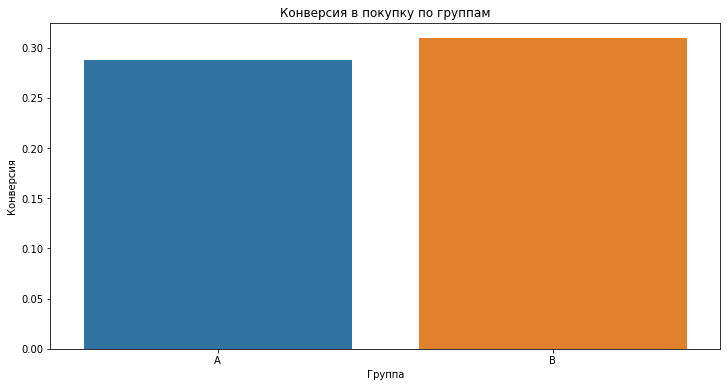

In [34]:
# Визуализация конверсий
plt.figure(figsize=(12,6))
sns.barplot(x = conversion_rates.index, y = conversion_rates.values)
plt.title('Конверсия в покупку по группам')
plt.ylabel('Конверсия')
plt.xlabel('Группа')
plt.show()

- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

Группа В, которая имела дело с новым интерфейсом, была чуть более многочисленной по составу, чем контрольная группа А. Конверсия в группе В также оказалась чуть больше, чем в группе А - 0.31 (около 31%) против 0.29 (около 29%). Согласно рассчетам, изменение конверсии составило всего 2,2%, что меньше ожидаемого в техническом задании (3%). Предварительно можно сделать вывод о недостаточной эффективности внедрения нового интерфейса. Однако для окончательного вердикта требуется оценить статистическую значимость полученного результата.

## Проведем оценку результатов A/B-тестирования:

**Гипотезы исследования:** конверсия в покупку у пользователей благодаря новому интерфейсу должна увеличиться минимум на 3% по сравнению с пользователями, имеющими дело со старым интерфейсом сайта.

- H₀ (нулевая гипотеза): Конверсия в покупку в тестовой группе (новый интерфейс) не превышает конверсию в контрольной группе (старый интерфейс)

- H₁ (альтернативная гипотеза): Конверсия в покупку в тестовой группе выше, чем в контрольной, и это различие статистически значимо

- Проверим изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

In [35]:
# Применим Z-тест пропорций для оценки статистической значимости результата
successes = [purchase_counts.get('B', 0), purchase_counts.get('A', 0)]
nobs = [total_users.get('B', 0), total_users.get('A', 0)]
stat_z, p_value_z = proportions_ztest(successes, nobs, alternative = 'larger')
print(f'\nZ-тест пропорций: Z-статистика= {stat_z:.4f}, p-value = {p_value_z:.4f}')
if p_value_z < 0.05:
    print('Нулевая гипотеза отвергается: конверсия в тестовой группе выше')
else:
    print('Нулевая гипотеза подтверждается: нет доказательств, что конверсия в тестовой группе выше')


Z-тест пропорций: Z-статистика= 2.4551, p-value = 0.0070
Нулевая гипотеза отвергается: конверсия в тестовой группе выше


Статистическая значимость полученного результата подтверждена

- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

По результатам А/В-тестирования удалось установить, что конверсия в покупку среди тестовой группы, пользовавшейся версией сайта с обновленным интерфейсом, оказалась выше, чем в контрольной группе, пользовавшейся старой версией сайта. Однако положительная динамика составила всего 2,2% вместо ожидавшихся как минимум 3%. Статистический тест подтверждает значимость полученного результата. Таким образом, разработка нового интерфейса позволила добиться эффекта в изменении конверсии, однако он оказался недостаточным. В связи с этим рекомендуется рассмотреть возможность и других нововведений, которые были бы способны улучшить конверсию до желаемого уровня.